In [7]:
import os
import json
import sys
import glob
import matplotlib.pyplot as plt
import pickle as pkl
from pathlib import Path
# % matplotlib inline
sys.path.append("../") # Append visdialch path
import argparse
import numpy as np
from pprint import pprint

In [8]:
import numpy as np
from visdialch.metrics import NDCG
from typing import List
import torch

In [9]:
# % matplotlib inline

In [10]:
class PredictionsAnalyzer:
    """
    gt_index, gt_ans_relevance are found by get_dialog_by_row_index

    gt_index -> 0-index
    gt_round_id -> 1-index
    ranks -> 1-index
    ranks_json['round_id'] -> 1-index
    gt_relevance -> List

    # ranks_json => list of dic -> dict_keys(['image_id', 'round_id', 'ranks'])
    # annotations_json list of dic -> dict_keys(['image_id', 'round_id', 'gt_relevance'])
    # dialog_json list of dic -> dict_keys(['questions', 'answers', 'dialog'])
                                -> [''image_id', 'answer_options']

    Answer options -> [3456, 677, 888] # option idx from all answers
    gt_relevance -> [0.4, 0.5, ....]  # relevance of options by index
    Ranks json -> [100, 1, ....]  # ranks of all options
        Indices are same as before..but their new ranks are shown
        instead of their indices being shown
        Eg. [5, 6, 8, ...]  means that original 0-index option is now 5th rank
    """
    def __init__(self, path_val_data, dense_annotations_jsonpath,
                 path_images_root, model_preds_root):
        self.path_val_data = path_val_data
        self.dense_annotations_jsonpath = dense_annotations_jsonpath
        # Ideally return the q and a here
        self.read_data()
        self.path_images_root = path_images_root
        self.model_preds_root = model_preds_root
        self.img_folder_list = self.get_img_folder_list(self.path_images_root)
        self.img_map = self.get_img_map(self.img_folder_list)
        self.models_list = self.get_model_type_list(self.model_preds_root)
        self.gt_indices_list = []  # 0-indexed
        self.gt_relevance_list = []
        self.ndcg = NDCG(is_direct_ranks=True)

    def get_models_list(self):
        return self.models_list


    def read_data(self):
        self.data_val = json.load(open(self.path_val_data))
        self.questions = self.data_val['data']['questions']
        print("Total questions:", len(self.questions))
        self.answers = self.data_val['data']['answers']
        print("Total answers:", len(self.answers))
        self.annotations_json = json.load(open(self.dense_annotations_jsonpath))
        return

    @staticmethod
    def get_img_folder_list(path_images_root, image_folder_name="VisualDialog_val2018"):
        path_visdial_val = os.path.join(path_images_root, image_folder_name)
        img_folder_list = glob.glob(os.path.join(path_visdial_val, '*'))
        print("Total images in folder:", len(img_folder_list))
        return img_folder_list

    @staticmethod
    def get_model_type_list(model_preds_root):
        model_folder_list = [os.path.basename(x) for x in glob.glob(os.path.join(model_preds_root, '*'))]
        print("Total models in folder:", len(model_folder_list))
        return model_folder_list

    @staticmethod
    def json_load(file_path):
        with open(file_path, "r") as fb:
            data = json.load(fb)
        return data

    @staticmethod
    def convert_list_json_dic(ranks_json):
        image_ranks_dic = {}
        for i in range(len(ranks_json)):
            image_ranks_dic[ranks_json[i]["image_id"]] = ranks_json[i]
        return image_ranks_dic

    @staticmethod
    def image_id_from_path(image_path):
        """Given a path to an image, return its id.

        Parameters
        ----------
        image_path : str
            Path to image, e.g.: coco_train2014/COCO_train2014/000000123456.jpg
            img_name = "VisualDialog_val2018_000000254080.jpg"
        Returns
        -------
        int
            Corresponding image id (123456)
        """
        return int(image_path.split("/")[-1][-16:-4])

    def get_img_map(self, img_folder_list):
        img_map = dict()
        for img_path in img_folder_list:
            img_id = self.image_id_from_path(img_path)
            img_map[img_id] = img_path
        return img_map

    def show_img(self, img_id):
        img_path = self.img_map[img_id]
        print("Reading image from: ", img_path)
        plt.imshow(plt.imread(img_path))
        plt.show()

    def get_both_phase_ranks(self, model_type,
                             ranks_phase1_file="ranks_val_12_crowdsourced.json",
                             ranks_finetune_file="ranks_val_best_ndcg_crowdsourced.json"):
        """

        :param model_type:
        :param ranks_phase1_file:
        :param ranks_finetune_file:
        :return:
        """
        model_rank_phase1_path = Path(self.model_preds_root, model_type, ranks_phase1_file)
        model_rank_finetune_path = Path(self.model_preds_root, model_type, ranks_finetune_file)
        # list of dic -> dict_keys(['image_id', 'round_id', 'ranks'])

        ranks_phase1_json = self.json_load(model_rank_phase1_path)
        ranks_finetune_json = self.json_load(model_rank_finetune_path)
        return ranks_phase1_json, ranks_finetune_json

    def subset_val_ranks_with_dense_annotation(self, ranks_json, top_k=5):
        """
        this is because val ranks consists of 10 turns
        :param ranks_json:
                round_id - 1-index
                ranks - still 1-index
        :param top_k:
        :return:
        """
        rank_dense_list = []
        relevance_dic = {}
        index_dic = {}
        gt_results_index_dic = {}
        # gt_results_relevance_dic = {}

        gt_indices_list = []  # 0-indexed
        gt_relevance_list = []

        dialogs = self.data_val['data']['dialogs']

        for i in range(len(self.annotations_json)):
            # They will be in same order by image_id
            round_id = self.annotations_json[i]['round_id'] - 1  # for 0-indexing
            index_for_ranks_json = i * 10 + round_id
            assert ranks_json[index_for_ranks_json]['round_id'] == round_id + 1  # Check with 1-indexing in ranks json
            assert ranks_json[index_for_ranks_json]['image_id'] == self.annotations_json[i]['image_id']
            gt_relevance = self.annotations_json[i]['gt_relevance']
            rank_dense_list.append(ranks_json[index_for_ranks_json])
            ranks = ranks_json[index_for_ranks_json]['ranks']
            relevance_sum = 0
            image_id = ranks_json[index_for_ranks_json]['image_id']

            # To actually have the indices_list and relevance list before hand
            assert image_id == dialogs[i]['image_id']
            assert image_id == self.annotations_json[i]['image_id']
            
            # round_id already 0-index gt_index also 0-indexed            
            gt_index = dialogs[i]['dialog'][round_id]['gt_index']
            gt_ans_relevance = gt_relevance[gt_index]
            gt_indices_list.append(gt_index)
            gt_relevance_list.append(gt_ans_relevance)
            # We need to find rank of (gt_index + 1) - coz ranks are 1-indexed
            pred_index = ranks.index(gt_index + 1)  # maintaining 0-index

            if pred_index in gt_results_index_dic:
                # gt_results_index_dic[pred_index].append(image_id)
                gt_results_index_dic[pred_index].append(i)
            else:
                # gt_results_index_dic[pred_index] = [image_id]
                gt_results_index_dic[pred_index] = [i]

            for j in range(top_k):
                relevance_sum += gt_relevance[ranks[j] - 1]  # 0-indexing
            # We keep a list of relevance sum - kind of proxy to get the best scores
            if relevance_sum in relevance_dic:
                relevance_dic[relevance_sum].append(image_id)

                index_dic[relevance_sum].append(i)
            else:
                relevance_dic[relevance_sum] = [image_id]
                index_dic[relevance_sum] = [i]

        # Re-assign
        self.gt_indices_list = gt_indices_list
        self.gt_relevance_list = gt_relevance_list

        return rank_dense_list, relevance_dic, index_dic, gt_results_index_dic

    def print_dialog(self, dialog, gt_round_id, gt_ans_relevance, answer_options):
        """
        dialog -> per image
        gt_round_id -> should be 1-index
        """
        print("\n")
        print("Dialog: ")
        print("\n")
        for round_indx in range(gt_round_id - 1):
            print("Q{}".format(round_indx + 1), f"{self.questions[dialog[round_indx]['question']].capitalize()}?")
            print("A{}".format(round_indx + 1), f"{self.answers[dialog[round_indx]['answer']].capitalize()}.")
            print("\n")

        print("Current Q{}: ".format(gt_round_id), f"{self.questions[dialog[gt_round_id - 1]['question']].capitalize()}?")
        print("\n")
        print("GT answer: ", f"{self.answers[dialog[gt_round_id - 1]['answer']].capitalize()}.")
        gt_ans_index = dialog[gt_round_id - 1]['answer']
        found_ans_index = answer_options.index(gt_ans_index)  # returns 0-index
#         print("GT index: ", dialog[gt_round_id - 1]['gt_index'])
        gt_index = dialog[gt_round_id - 1]['gt_index']
        assert found_ans_index == gt_index
        print("GT relevance: ", gt_ans_relevance)
        print("\n")

    def get_dialog_by_row_index(self, row_index, is_print):
        """
        :param row_index: defines the whole dialog (not turn)
        :return:
        """
        caption = self.data_val['data']['dialogs'][row_index]['caption']
        dialog = self.data_val['data']['dialogs'][row_index]['dialog']
        image_id = self.data_val['data']['dialogs'][row_index]['image_id']
        # This is for turn
        dense_annotations = self.annotations_json[row_index]
        # print(dense_annotations.keys())
        gt_round_id = dense_annotations["round_id"]  # Already 1-index
        gt_image_id = dense_annotations["image_id"]
        assert gt_image_id == image_id
        gt_relevance = dense_annotations["gt_relevance"]
        assert len(gt_relevance) == 100
        gt_index = dialog[gt_round_id - 1]['gt_index']
        gt_ans_relevance = gt_relevance[gt_index]
        answer_options = dialog[gt_round_id - 1]["answer_options"]
        
        if is_print:
            print(f"{caption.capitalize()}.")
            self.show_img(image_id)
            self.print_dialog(dialog, gt_round_id, gt_ans_relevance, answer_options)
            
            non_zero_relevant_ans = np.count_nonzero(gt_relevance)
            print("Number of answers with non-zero relevance: ", non_zero_relevant_ans)            
            
        return answer_options, gt_index, gt_relevance

    def print_top_k_preds(self, ranks_model, gt_index, gt_relevance,
                          answer_options, phase, top_k=5):
        """
        gt_index -> should be 0-index
        ranks_model -> 0-index
        """
        print("\n")
        print(f"- {phase} Phase: ")
        # Get rank of gt_index
#         pred_index = ranks_model.index(gt_index) + 1  # to convert to 1-index for print
#         print("GT answer predicted at: ", pred_index)
#         print("GT answer is: ", self.answers[answer_options[ranks_model[pred_index-1]]]) # Checked

        print("GT predicted at rank: ", ranks_model[gt_index] + 1) # gt rank 0-index
        indices_list = sorted(range(len(ranks_model)), key=lambda i: ranks_model[i])[:top_k]        
        self.get_ndcg_value_wrapper(ranks=ranks_model, gt_relevance=gt_relevance)
        print("\n")
        for i in range(top_k):
            print("Relevance:", gt_relevance[indices_list[i]], "Answer:", f"{self.answers[answer_options[indices_list[i]]].capitalize()}.")
        print("\n")

    def get_ndcg_value_wrapper(self, ranks: List,
                               gt_relevance : List):
        """

        :param ranks: list
        :param gt_relevance: list
        :return:
        """
        # (batch_size, num_options)
        ranks = torch.tensor(ranks).float()
        gt_relevance = torch.tensor(gt_relevance).float()
        # If individual sample, we need to add 0-dim
        if len(ranks.size()) == 1:
            ranks = ranks.unsqueeze(0)
            gt_relevance = gt_relevance.unsqueeze(0)
        self.ndcg.observe(ranks, gt_relevance)
        value = self.ndcg.retrieve(reset=True)["ndcg"]
        print(f"NDCG: {round(value*100,2)}")
        return value        
        
    def print_top_k_preds_wrapper(self, ranks_phase1_json, ranks_finetune_json,
                                  gt_index, gt_relevance, answer_options,
                                  row_index, top_k=5):
        assert len(ranks_phase1_json) == len(self.annotations_json)
        ranks_phase1 = ranks_phase1_json[row_index]["ranks"]
        ranks_finetune = ranks_finetune_json[row_index]["ranks"]
        # Ranks are 1 indexed - shifting to 0
        ranks_phase1 = [rank - 1 for rank in ranks_phase1]
        ranks_finetune = [rank - 1 for rank in ranks_finetune]
        self.print_top_k_preds(ranks_phase1, gt_index, gt_relevance,
                               answer_options, "Spare Annotation", top_k=top_k)
        self.print_top_k_preds(ranks_finetune, gt_index, gt_relevance,
                               answer_options, "Curriculum Finetuning", top_k=top_k)

    # Main api open to call
    def get_analysis(self, model_type, top_k=5, row_index=1, is_print=False):
        ranks_phase1_json, ranks_finetune_json = self.get_both_phase_ranks(model_type)

        ranks_phase1_json, relevance_dic_phase1, index_dic_phase1,\
        gt_results_index_dic_phase1 = self.subset_val_ranks_with_dense_annotation(
            ranks_phase1_json, top_k=top_k)

        ranks_finetune_json, relevance_dic_finetune, \
        index_dic_finetune, gt_results_index_dic_finetune = self.subset_val_ranks_with_dense_annotation(
            ranks_finetune_json, top_k=top_k)
        # For identifying row_index
        # print(relevance_dic_phase1)
        # print(relevance_dic_finetune)
        # print(index_dic_finetune)

        answer_options, gt_index, gt_relevance = self.get_dialog_by_row_index(row_index, is_print)
        self.print_top_k_preds_wrapper(ranks_phase1_json, ranks_finetune_json,
                                       gt_index, gt_relevance, answer_options,
                                       row_index, top_k=top_k)

        # return relevance_dic_phase1, relevance_dic_finetune, index_dic_finetune
        return

    # Return only once to find subsets
    def get_dic_models(self, model_type, top_k=5):
        ranks_phase1_json, ranks_finetune_json = self.get_both_phase_ranks(model_type)

        ranks_phase1_json, relevance_dic_phase1, \
        index_dic_phase1, gt_results_index_dic_phase1\
            = self.subset_val_ranks_with_dense_annotation(
            ranks_phase1_json, top_k=top_k)

        ranks_finetune_json, relevance_dic_finetune, \
        index_dic_finetune, gt_results_index_dic_finetune = self.subset_val_ranks_with_dense_annotation(
            ranks_finetune_json, top_k=top_k)

        return relevance_dic_phase1, relevance_dic_finetune, index_dic_phase1, \
               index_dic_finetune, gt_results_index_dic_phase1, \
               gt_results_index_dic_finetune

    @staticmethod
    def get_max_index(values):
        _index = values.index(max(values))
        return _index

    def list_ans_opts(self, answer_options, gt_relevance, gt_index, num_ans_opts=5):
        """
        To list answer options for the task
        :param answer_options:
        :param num_ans_opts:
        :return:
        """
        print_ans_opt_list = []
        print_relevance = []
        for ans_opt in range(num_ans_opts-1):
            print_ans_opt_list.append(self.answers[answer_options[ans_opt]])
            print_relevance.append(gt_relevance[ans_opt])
            # print(self.answers[answer_options[ans_opt]])
            # print(gt_relevance[ans_opt])

        # One we will print for max index
        max_score_index = self.get_max_index(gt_relevance)  # 0-index

        print_ans_opt_list.append(self.answers[answer_options[max_score_index]])
        print_relevance.append(gt_relevance[max_score_index])
        
        # GT
        print_ans_opt_list.append(self.answers[answer_options[gt_index]])
        print_relevance.append(gt_relevance[gt_index])

        print("Answers:")
        self.print_line_by_line(print_ans_opt_list)
        print("Relevance:")
        self.print_line_by_line(print_relevance)
        print("Last one is gt")
        # print(print_ans_opt_list)
        # print(print_relevance)
        # print(self.answers[answer_options[max_score_index]])
        # print(gt_relevance[max_score_index])

    @staticmethod
    def print_line_by_line(mylist):
        for elem in mylist:
            print(elem)

In [11]:
path_val_data = "../../data/crowdsourced/visdial_1.0_val_crowdsourced.json"
path_images_root = "../../data/images/"
dense_annotations_jsonpath = "../../data/crowdsourced/visdial_1.0_val_dense_annotations_crowdsourced.json"
model_preds_root = "../../models/visdialconv/"

analyzer = PredictionsAnalyzer(path_val_data,
                               dense_annotations_jsonpath,
                               path_images_root, model_preds_root)

model_type_list = analyzer.get_models_list()

print(model_type_list)

Total questions: 45237
Total answers: 34821
Total images in folder: 2064
Total models in folder: 4
['mcan_img_only', 'mcan_img_mcan_hist', 'mcan_img_mcan_vqa_hist_attn', 'hist_guided_qmcan']


In [12]:
top_k = 5


In [ ]:
row_index = 26

A clock with a rose on its corner sits on the wall.
Reading image from:  /scratch/shubham/visdial2019/data/images/VisualDialog_val2018/VisualDialog_val2018_000000446567.jpg


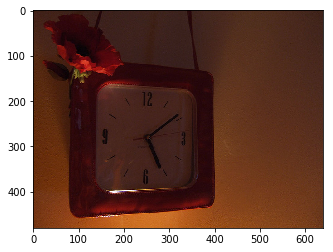



Dialog: 


Q1 Is it a real rose?
A1 I don't think so.


Q2 Is it an old fashion clock?
A2 No, not really.


Q3 Is it a digital clock?
A3 No.


Current Q4:  Is it hanging on the wall or leaning?


GT answer:  It's hanging.
GT relevance:  1.0


Number of answers with non-zero relevance:  3


- Spare Annotation Phase: 
GT predicted at rank:  1
NDCG: 81.55


Relevance: 1.0 Answer: It's hanging.
Relevance: 0.0 Answer: Yes, it's attached to the side of the building.
Relevance: 0.0 Answer: Yes.
Relevance: 0.0 Answer: It is cut out, but it is definitely sitting on something.
Relevance: 0.0 Answer: It looks like.




- Curriculum Finetuning Phase: 
GT predicted at rank:  2
NDCG: 51.45


Relevance: 0.0 Answer: It looks like.
Relevance: 1.0 Answer: It's hanging.
Relevance: 0.0 Answer: Can't tell.
Relevance: 0.0 Answer: Unclear.
Relevance: 0.0 Answer: I think so.




In [183]:
# MCA-I-H
analyzer.get_analysis(model_type_list[1], row_index=row_index, top_k=top_k, is_print=True)

In [184]:
# VGH-I
analyzer.get_analysis(model_type_list[2], row_index=row_index, top_k=top_k)



- Spare Annotation Phase: 
GT predicted at rank:  2
NDCG: 51.45


Relevance: 0.0 Answer: No it is not mounted on the wall.
Relevance: 1.0 Answer: It's hanging.
Relevance: 0.0 Answer: It is cut out, but it is definitely sitting on something.
Relevance: 0.0 Answer: Yes, it's attached to the side of the building.
Relevance: 0.0 Answer: On the rail.




- Curriculum Finetuning Phase: 
GT predicted at rank:  3
NDCG: 40.78


Relevance: 0.0 Answer: No it is not mounted on the wall.
Relevance: 0.0 Answer: Not sure.
Relevance: 1.0 Answer: It's hanging.
Relevance: 0.0 Answer: Can't tell.
Relevance: 0.0 Answer: I can't tell.




A family is enjoying the beach on a sunny day.
Reading image from:  /scratch/shubham/visdial2019/data/images/VisualDialog_val2018/VisualDialog_val2018_000000560666.jpg


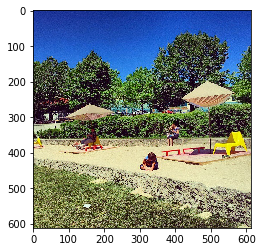



Dialog: 


Q1 How many people are there?
A1 3 people.


Q2 Is there a father and mother?
A2 Can't tell from the picture.


Q3 Are they building a sand castle?
A3 No just 1 kid playing in the sand.


Q4 Are there big waves?
A4 No the sea is not visible.


Q5 Are there other people visible?
A5 No other people are visible.


Q6 What is in the background?
A6 Trees and buildings.


Q7 How many are adults?
A7 1 adult.


Q8 What time of day is it?
A8 It looks like midday.


Q9 What is the other child doing?
A9 Looks like she's on a phone.


Current Q10:  What is the adult doing?


GT answer:  Just sitting relaxing.
GT relevance:  0.6


Number of answers with non-zero relevance:  9


- Spare Annotation Phase: 
GT predicted at rank:  1
NDCG: 53.24


Relevance: 0.6 Answer: Just sitting relaxing.
Relevance: 0.6 Answer: Just sitting.
Relevance: 0.0 Answer: Standing.
Relevance: 0.0 Answer: It is standing on the windowsill with its front feet outside.
Relevance: 0.0 Answer: He's on the phone, sitt

In [333]:
# ['mcan_img_only', 'mcan_img_mcan_hist', 'mcan_img_mcan_vqa_hist_attn', 'hist_guided_qmcan']

# MCA-I
analyzer.get_analysis(model_type_list[0], top_k=top_k, row_index=row_index, is_print=True)

In [278]:
# Hist guided
analyzer.get_analysis(model_type_list[3], row_index=row_index, top_k=top_k)



- Spare Annotation Phase: 
GT predicted at rank:  5
NDCG: 45.01


Relevance: 0.0 Answer: At least a dozen.
Relevance: 0.0 Answer: At least 20.
Relevance: 0.0 Answer: 30.
Relevance: 0.4 Answer: Around 8.
Relevance: 0.4 Answer: 7.




- Curriculum Finetuning Phase: 
GT predicted at rank:  17
NDCG: 49.03


Relevance: 0.0 Answer: At least a dozen.
Relevance: 0.0 Answer: At least 20.
Relevance: 0.0 Answer: There are people in the distance.
Relevance: 0.2 Answer: Not many.
Relevance: 0.8 Answer: Looks about 7.




In [210]:
row_index = 0

## color, numbers, similar to yes/no answers, what -> color, 





# Get Sample Dialog

# 1. To get sample dialog for paper
row_index = 6
num_ans_opts = 5
answer_options, gt_index, gt_relevance = analyzer.get_dialog_by_row_index(row_index, is_print=True)
analyzer.list_ans_opts(answer_options, gt_relevance, gt_index, num_ans_opts=num_ans_opts)

In [212]:
dense_annotations_jsonpath = "../../data/crowdsourced/visdial_1.0_val_dense_annotations_crowdsourced.json"
with open(dense_annotations_jsonpath, "r") as fb:
    data = json.load(fb)
# data[0]